<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the Data</a></span></li><li><span><a href="#Model-the-Data-with-DD-SIMCA" data-toc-modified-id="Model-the-Data-with-DD-SIMCA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model the Data with DD-SIMCA</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Create-a-Classifier" data-toc-modified-id="Create-a-Classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create a Classifier</a></span></li><li><span><a href="#Optimizing-the-Classifier" data-toc-modified-id="Optimizing-the-Classifier-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimizing the Classifier</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook

import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import sys
sys.path.append('../../')
import chemometrics

import numpy as np
import pandas as pd

import watermark
%load_ext watermark

/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and wil

Overview
--------
This is a simple example of using DD-SIMCA to do some analysis.

In [2]:
%watermark -t -m -v --iversions

imblearn  0.5.0
numpy     1.21.4
pandas    0.25.1
sklearn   0.22.2.post1
watermark 2.0.2
15:55:19 

CPython 3.7.4
IPython 7.8.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-163-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


# Load the Data

In [3]:
# Let's load some data from the tests/ for this example
df = pd.read_csv('../tests/data/simca_train.csv')

In [4]:
# You can see that samples are rows, columns are different features
df

,Group,Class,Name,3999,3991,3983,3975,3967,3959,3951,...,527,519,511,503,495,487,479,471,463,455
0,1,Pure,F 16 08 001 D,-0.968873,-0.969487,-0.970409,-0.969794,-0.970101,-0.971944,-0.970409,...,2.629155,2.652808,2.665095,2.684140,2.700114,2.693664,2.721617,2.728067,2.718238,2.668986
1,1,Pure,F 16 08 002 D,-0.965465,-0.964848,-0.965465,-0.966697,-0.966389,-0.968238,-0.968546,...,2.669310,2.672083,2.703205,2.711524,2.749117,2.733402,2.765756,2.758977,2.775000,2.714092
2,1,Pure,F 16 08 003 D,-0.968031,-0.969617,-0.968665,-0.970568,-0.970568,-0.970568,-0.971203,...,2.538191,2.525503,2.544218,2.570861,2.570544,2.567690,2.566421,2.566739,2.547390,2.592536
3,1,Pure,F 16 08 005 D,-0.957622,-0.957622,-0.958654,-0.958654,-0.960374,-0.959686,-0.957622,...,2.626278,2.622494,2.646919,2.666528,2.685448,2.685792,2.708497,2.693705,2.689920,2.707809
4,1,Pure,F 16 08 006 D,-0.960211,-0.961166,-0.961166,-0.961803,-0.961803,-0.962758,-0.963713,...,2.698431,2.711802,2.710846,2.746185,2.777385,2.767516,2.800307,2.807311,2.764331,2.773564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1,Pure,F 16 10 073 D,-0.969603,-0.969603,-0.966800,-0.967267,-0.969136,-0.966800,-0.969136,...,2.636443,2.648588,2.671476,2.672410,2.735469,2.735937,2.742009,2.776107,2.732200,2.722234
68,1,Pure,F 16 10 075 D,-0.955665,-0.957460,-0.956024,-0.958178,-0.958178,-0.958178,-0.960692,...,2.701744,2.707488,2.719695,2.747340,2.732261,2.743750,2.733338,2.737647,2.741955,2.696239
69,1,Pure,F 16 10 076 D,-0.970511,-0.968855,-0.972167,-0.971339,-0.974236,-0.971753,-0.972580,...,2.724657,2.727968,2.746593,2.754457,2.782601,2.801640,2.832681,2.874069,2.798743,2.745627
70,1,Pure,F 16 10 078 D,-0.966621,-0.964083,-0.967637,-0.967637,-0.965606,-0.967637,-0.967637,...,2.693649,2.694664,2.704819,2.753562,2.762701,2.781995,2.783518,2.802812,2.751531,2.759993


In [5]:
raw_x = np.array(df.values[:,3:], dtype=float) # Extract features
raw_y = np.array(df['Class'].values, dtype=str) # Take the class as the target

# Model the Data with DD-SIMCA

In [6]:
from chemometrics.classifier.simca import DDSIMCA_Model

## Training

In [7]:
# Here the data is spectra so we will not scale the X data
dds = DDSIMCA_Model(n_components=7, alpha=0.05, gamma=0.01, scale_x=False)

In [8]:
_ = dds.fit(raw_x, raw_y)

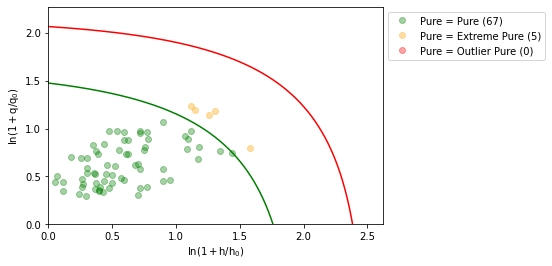

In [9]:
_ = dds.visualize(raw_x, raw_y)

In [10]:
# We can see what samples are classified as 'Pure' using the predict() function.
pure_sample_mask = dds.predict(raw_x)
len(pure_sample_mask)

72

In [11]:
# We could extract that data as follows:
pure = raw_x[pure_sample_mask]

In [12]:
# Extremes and Outliers can be found using the check_outliers() function.
extremes_mask, outliers_mask = dds.check_outliers(raw_x)

In [13]:
# We could extract that data as follows:
extremes = raw_x[extremes_mask]
outliers = raw_x[outliers_mask]

In [14]:
# Number of outliers, for example?
np.sum(outliers_mask)

0

In [15]:
# Number of extremes, for example?
np.sum(extremes_mask)

5

## Testing

First, let's test on other pure samples that weren't in the training set.

In [16]:
df = pd.read_csv('../tests/data/simca_test.csv')
raw_x_t = np.array(df.values[:,3:], dtype=float)
raw_y_t = np.array(df.values[:,1], dtype=str)

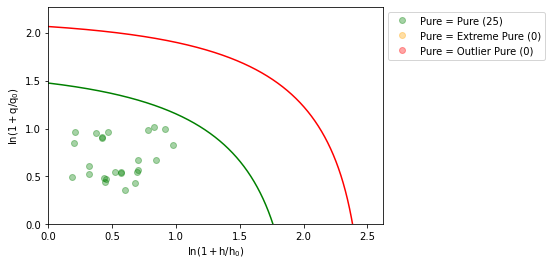

In [17]:
# Here, we would like to see all the points fall INSIDE the green acceptance region since we know they
# all belong to the 'Pure' class.
_ = dds.visualize(raw_x_t, raw_y_t)

We could also check against known alternates.

In [18]:
df = pd.read_csv('../tests/data/simca_test_alt.csv', header=None)
raw_x_a = np.array(df.values[:,3:], dtype=float)
raw_y_a = np.array(df.values[:,1], dtype=str)

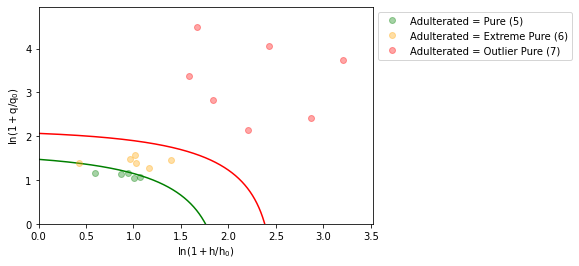

In [19]:
# Here, we would like to see all the points fall OUTSIDE the green acceptance region since we know they
# are not the 'Pure' class.
_ = dds.visualize(raw_x_a, raw_y_a)

# Create a Classifier

In the last section, we just created a DD-SIMCA Model. In practice, we would like to turn that into a classifier.  

In [20]:
from chemometrics.classifier.simca import SIMCA_Classifier

In [21]:
sc = SIMCA_Classifier(n_components=7, 
                      alpha=0.05, 
                      scale_x=False, 
                      style='dd-simca', 
                      target_class='Pure', 
                      use='TEFF')

In [22]:
# Combine the training (all Pure) and alternate data to create a new training set that has multiple (in this
# case 2) classes.  We specified the target_class='Pure' above, which tells the classifier that we are trying
# to model that class.  ONLY that data is used to fit the model; all other classes it is provided will be
# ignored.
x_train = np.vstack((raw_x, raw_x_a))
y_train = np.hstack((raw_y, raw_y_a))
_ = sc.fit(x_train, y_train)

In [23]:
# By default, TEFF is used to score the classifer, you can change this when then classifier is instantiated.
sc.score(x_train, y_train) # TEFF = sqrt(TSNS * TSPS)

0.8197974757429837

In [24]:
sc.TSNS, sc.TSPS, sc.TEFF

(0.9305555555555556, 0.7222222222222222, 0.8197974757429837)

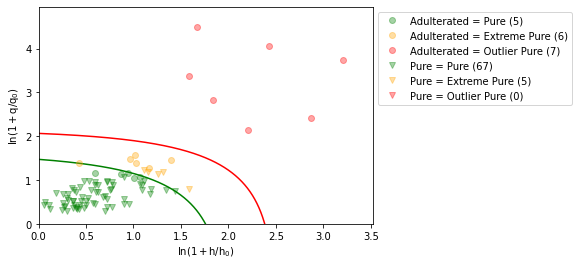

In [25]:
# Look at all the data.
sc.model.visualize(x_train, y_train)

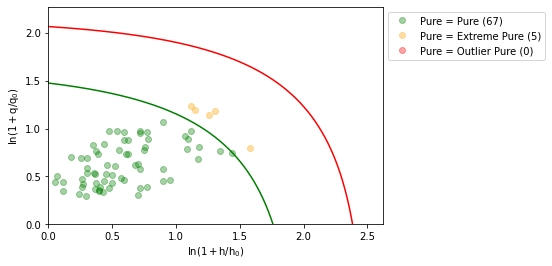

In [26]:
# Look at just the data used to train the underlying SIMCA_Model.
sc.model.visualize(raw_x, raw_y)

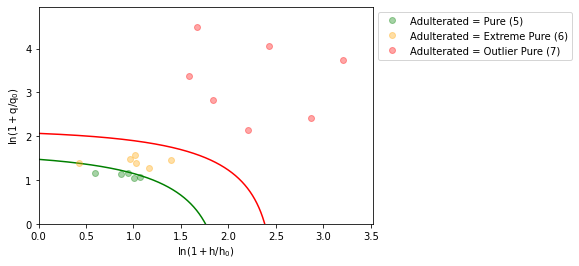

In [27]:
# Look at the data used to test how well the model performs by classifying alternative samples.
sc.model.visualize(raw_x_a, raw_y_a)

# Optimizing the Classifier

Here we took alpha as a meaningful choice of type I error rate, but it could also be adjusted.  Moreover, we arbitrarily selected the number of PCs to use in the SIMCA model.  We can use scikit-learn's pipelines to automatically optimize hyperparameters like this.

In [67]:
# Here I've use an imblearn pipeline, but you can also use scikit-learn's pipeline if you don't want to 
# do any class balancing.

pipeline = imblearn.pipeline.Pipeline(steps=[
    # Insert other preprocessing steps here...
    # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
    ("simca", SIMCA_Classifier(n_components=7, 
                               alpha=0.05, 
                               scale_x=False, 
                               style='dd-simca', 
                               target_class='Pure', 
                               use='TEFF')
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    # 'smote__k_enn':[1, 2, 3],
    # 'smote__k_smote':[1, 3, 3],
    # 'smote__kind_sel_enn':['all', 'mode'],
    'simca__n_components':np.arange(1, 10),
    #'simca__alpha':[0.07, 0.05, 0.03, 0.01],
    #'simca__style':['dd-simca', 'simca'],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(x_train, y_train)

In [68]:
# The best parameters found can be accessed like this:
gs.best_params_

{'simca__n_components': 6}

In [69]:
gs.best_score_ # The best score it recieved was...

0.8413590987427072

In [70]:
# You can see detailed CV results here
gs.cv_results_

{'mean_fit_time': array([0.30326374, 0.28212611, 0.35160867, 0.24655326, 0.30190007,
        0.2085797 , 0.22400387, 0.15863276, 0.13817771]),
 'std_fit_time': array([0.08719398, 0.02960608, 0.07069978, 0.05644194, 0.01043722,
        0.02503004, 0.02231856, 0.02503231, 0.02232168]),
 'mean_score_time': array([0.0245595 , 0.01143607, 0.0029401 , 0.0104653 , 0.00163221,
        0.00414181, 0.0017213 , 0.00415166, 0.00182486]),
 'std_score_time': array([5.91685337e-03, 6.90501848e-03, 1.88106925e-03, 1.25266560e-02,
        9.27281753e-05, 3.43737760e-03, 1.62517471e-04, 3.31493604e-03,
        4.27295362e-04]),
 'param_simca__n_components': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'simca__n_components': 1},
  {'simca__n_components': 2},
  {'simca__n_components': 3},
  {'simca__n_components': 4},
  {'simca__n_compon

Text(0, 0.5, 'Mean Test Score (TEFF)')

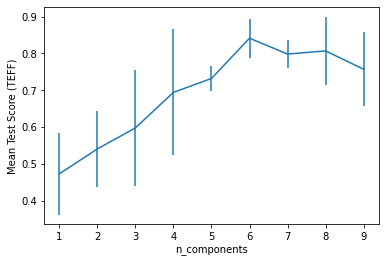

In [71]:
# For a 1D optimization you can easily visualize where the best value is
plt.errorbar(np.arange(1, 10), gs.cv_results_['mean_test_score'], yerr=gs.cv_results_['std_test_score'])
plt.xlabel('n_components')
plt.ylabel('Mean Test Score (TEFF)')

In [72]:
# The refit=True (default) refits the model on the data in the end so you can use it directly.
gs.best_estimator_.predict(raw_x) # raw_x was just Pure

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True])

In [73]:
gs.best_estimator_.predict(raw_x_a) # raw_x_a was just Alternates

array([ True, False, False,  True, False, False,  True,  True, False,
        True, False, False, False, False, False,  True, False, False])

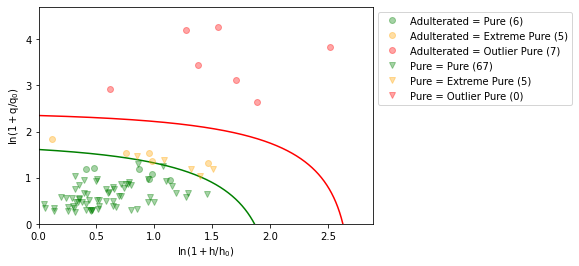

In [74]:
gs.best_estimator_.named_steps['simca'].model.visualize(x_train, y_train)

In [54]:
gs.best_estimator_.named_steps['simca'].score(x_train, y_train) # The score being used here is TEFF

0.7876359377087682

In [55]:
gs.best_estimator_.named_steps['simca'].TSNS # 67 / (67+5)

0.9305555555555556

In [56]:
gs.best_estimator_.named_steps['simca'].TSPS # 1 - 6/(6+5+7)

0.6666666666666667

In [57]:
gs.best_estimator_.named_steps['simca'].TEFF # sqrt(TSPS*TSNS)

0.7876359377087682